In [44]:
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms as T

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

%cd ../
from src.data.datasets import HandwritingDataset
from src.models import HandwritingClassifier
%cd notebooks/

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/nazar/Projects/ukrainian_handwriting
/home/nazar/Projects/ukrainian_handwriting/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0")

# Loading train/test/val

In [3]:
MEAN = HandwritingClassifier._mean
STD = HandwritingClassifier._std

In [4]:
tf = T.Compose([
    T.RandomRotation(30),
    T.RandomAffine(0, (0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD)
])

In [5]:
train_data = HandwritingDataset(
    '../data/processed/train_data.csv',
    transforms=tf
)

test_data = HandwritingDataset(
    '../data/processed/test_data.csv',
    transforms=T.Compose([
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
)

print('Number of samples in training data:', len(train_data))
print('Number of samples in test data:', len(test_data))

Number of samples in training data: 1281
Number of samples in test data: 300


In [6]:
BATCH_SIZE = 64
VAL_SIZE = 100

indices = list(range(len(train_data)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[VAL_SIZE:], indices[:VAL_SIZE]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_data, sampler=val_sampler)
test_loader = DataLoader(test_data)

# Functions for training

In [12]:
def compute_accuracy(model, loader):
    model.eval()
    correct_samples = 0
    total_samples = 0
    preds = []
    gt = []
    for i, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = torch.argmax(model(x_gpu), 1)
        
        preds.append(int(prediction))
        gt.append(int(y))
        
        correct_samples += torch.sum(prediction == y_gpu)
        total_samples += y.shape[0]
    return float(correct_samples) / total_samples, preds, gt

def train_model(model, train_loader, val_loader, optimizer, loss, num_epochs, scheduler=None):
    loss_history = []
    val_l_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_acum = 0
        total_samples = 0
        correct_samples = 0
        for i, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_acum += loss_value.item()
        
        average_loss = loss_acum / i
        train_accuracy = float(correct_samples) / total_samples
        
        model.eval()
        correct_samples = 0
        total_samples = 0
        loss_acum = 0
        
        for i, (x, y, _) in enumerate(val_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
        
            logits = model(x_gpu)
            loss_acum += loss(logits, y_gpu).item()
            prediction = torch.argmax(logits, 1)
        
            correct_samples += torch.sum(prediction == y_gpu).item()
            total_samples += y.shape[0]
        
        val_accuracy = correct_samples / total_samples
        val_loss = loss_acum / i
        
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        loss_history.append(average_loss)
        val_l_history.append(val_loss)
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f'{epoch + 1}. Loss = {average_loss:.6f}; Val loss = {val_loss:.6f};\
 Train accuracy = {train_accuracy:.6f}; Val accuracy = {val_accuracy}')
    return loss_history, val_l_history, train_history, val_history

def plot_history(loss_h, val_l_h, train_h, val_h) -> None:
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))
    ax[0].set_title('Train/validation Loss')
    ax[0].plot(loss_h, label='Train')
    ax[0].plot(val_l_h, label='Validation')
    ax[0].legend()
    ax[1].set_title('Train/validation accuracy')
    ax[1].plot(train_h, label='Train')
    ax[1].plot(val_h, label='Validation')
    ax[1].legend();

# Model training

In [35]:
model = HandwritingClassifier()
model.load_state_dict(torch.load('../models/mnist_model.pt'))

<All keys matched successfully>

In [36]:
num_features = model.class_fc.in_features
model.class_fc = nn.Linear(num_features, 43)

In [47]:
with open('../models/best_params.json', 'r') as f:
    params = json.load(f)

In [37]:
LR = params['learning_rate']
NUM_EPOCHS = params['num_epochs']
REG = params['weight_decay']
GAMMA = params['factor']
PAT = params['patience']

model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=REG)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=GAMMA, patience=PAT)

In [38]:
loss_history, val_l_history, train_history, val_history = train_model(model, train_loader, val_loader, optimizer,
                                                                      loss, NUM_EPOCHS, scheduler)

1. Loss = 3.426138; Val loss = 2.648913; Train accuracy = 0.249788; Val accuracy = 0.32
2. Loss = 2.441645; Val loss = 2.259573; Train accuracy = 0.414056; Val accuracy = 0.35
3. Loss = 2.007340; Val loss = 1.982801; Train accuracy = 0.502117; Val accuracy = 0.47
4. Loss = 1.682699; Val loss = 1.663464; Train accuracy = 0.570703; Val accuracy = 0.52
5. Loss = 1.484767; Val loss = 1.663421; Train accuracy = 0.616427; Val accuracy = 0.48
6. Loss = 1.320036; Val loss = 1.631268; Train accuracy = 0.641829; Val accuracy = 0.6
7. Loss = 1.185241; Val loss = 1.205278; Train accuracy = 0.688400; Val accuracy = 0.59
8. Loss = 1.062774; Val loss = 1.059600; Train accuracy = 0.708721; Val accuracy = 0.68
9. Loss = 1.028181; Val loss = 1.168908; Train accuracy = 0.735817; Val accuracy = 0.68
10. Loss = 0.936920; Val loss = 1.289642; Train accuracy = 0.757832; Val accuracy = 0.62
11. Loss = 0.912487; Val loss = 1.205818; Train accuracy = 0.752752; Val accuracy = 0.64
12. Loss = 0.913272; Val loss =

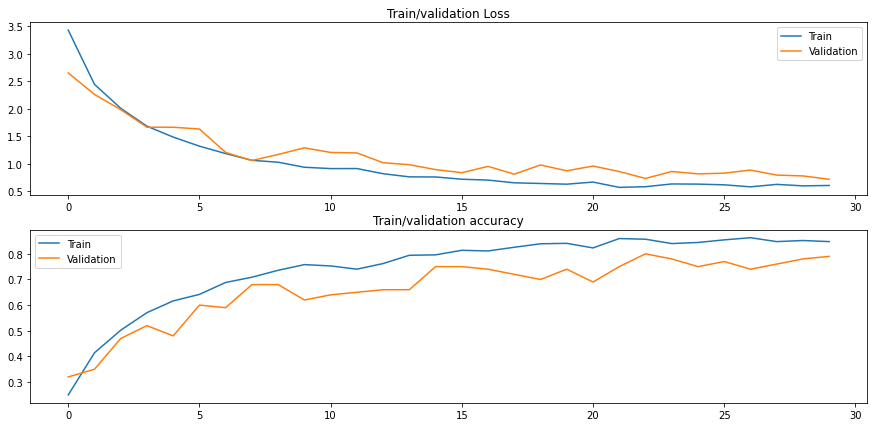

In [39]:
plot_history(loss_history, val_l_history, train_history, val_history)

In [40]:
test_acc, preds, gt = compute_accuracy(model, test_loader)

In [50]:
print(f'Accuracy on test dataset: {test_acc:.2%} ({test_acc})')

Accuracy on test dataset: 91.33% (0.9133333333333333)


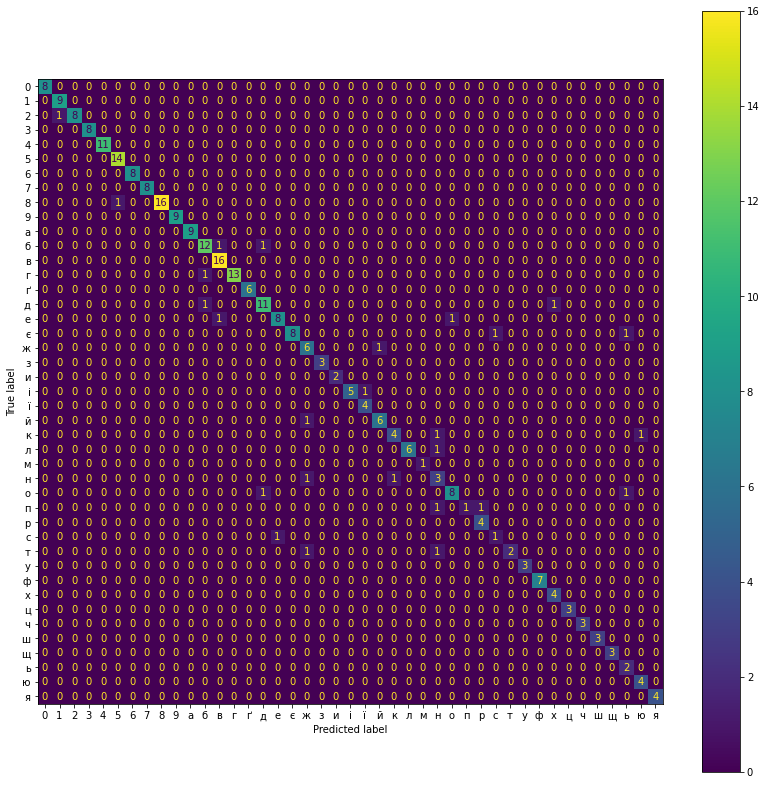

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
labels = list('0123456789абвгґдеєжзиіїйклмнопрстуфхцчшщьюя')
ConfusionMatrixDisplay.from_predictions(gt, preds, display_labels=labels, ax=ax);

In [43]:
# save model
torch.save(model.state_dict(), '../models/complete_model_v1.pt')